In [1]:
%load_ext autotime

time: 205 µs


In [2]:
import numpy as np
import _pickle as pickle
import pandas as pd

time: 780 ms


In [3]:
print("==========LOADING DATA==========")
age_seq = pickle.load(open("../data/new_age_seq","rb"))
sex_seq = pickle.load(open("../data/new_sex_seq","rb"))
        
util_seq = pickle.load(open("../data/new_util_seq","rb"))
code_seq = pickle.load(open("../data/new_code_seq","rb"))
date_seq = pickle.load(open("../data/new_date_seq","rb"))
label_seq = pickle.load(open("../data/new_label_seq","rb"))

==========LOADING DATA==========
time: 185 ms


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

time: 3.28 s


In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, seqs, vocab_sizes, list_IDs, max_visit, max_code, batch_size=100, shuffle=True):
        self.seqs = seqs
        self.code_vocab = vocab_sizes[0]
        self.cat_vocab = vocab_sizes[1]
        self.list_IDs = list_IDs
        self.max_visit = max_visit
        self.max_code = max_code
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch' 
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        demo_feature, code_feature, util_feature, date_feature, cls_feature = self.seqs
        batch_demo, batch_code, batch_util, batch_date, batch_cls = [], [], [], [], []
        for i, ID in enumerate(list_IDs_temp):
            batch_demo.append(demo_feature[ID])
            batch_code.append(code_feature[ID])
            batch_util.append(util_feature[ID])
            batch_date.append(date_feature[ID])
            batch_cls.append(cls_feature[ID])
        
        batch_demo_feature = np.array(batch_demo)
        batch_code_feature = self.code_padding(batch_code)
        batch_util_feature = self.date_padding(batch_util)
        batch_date_feature = self.date_padding(batch_date)
        batch_cls = np.array(batch_cls)
        
        dic = (
            {
                'demo_feature': batch_demo_feature,
                'code_feature': batch_code_feature,
                'util_feature': batch_util_feature,
                'date_feature': batch_date_feature,
            },
            {
                'cls_label': batch_cls
            })
        return dic
    
    def date_padding(self, seq):
        seq = [x[:-1] for x in seq]
        
        pad_seq = np.zeros((len(seq), self.max_visit))
        for i, p in enumerate(seq):
            pad_seq[i][:len(p)] = p[:self.max_visit]
        return pad_seq
    
    def code_padding(self, seq):
        seq = [x[:-1] for x in seq]
        
        X = np.zeros((len(seq), self.max_visit, self.max_code))
        for i, p in enumerate(seq):
            if len(p) > self.max_visit: 
                p = p[:self.max_visit]
            for j, claim in enumerate(p):
                claim = claim[:self.max_code]
                X[i][j][:len(claim)] = claim
        return X


time: 5.82 ms


In [6]:
def create_code_mask(code_seq):
    code_mask = tf.cast(tf.math.not_equal(code_seq, 0), tf.float32)
    return code_mask[:,:,:,tf.newaxis]

def create_visit_mask(seq):
    visit_mask = tf.cast(tf.math.not_equal(seq, 0), tf.float32)
    return visit_mask[:,:]

def scaled_dot_product_attention(Q, K, V, Q_masks, K_masks):
    d_k = K.get_shape().as_list()[-1] # d_model/h

    outputs = tf.matmul(Q, tf.transpose(K, [0, 2, 1]))  # (h*N, T_q, T_k)
    outputs /= d_k ** 0.5

    padding_num = -1e+7
    K_masks = tf.expand_dims(K_masks, 1) # (h*N, 1, T_k)
    K_masks = tf.tile(K_masks, [1, tf.shape(Q)[1], 1]) # (h*N, T_q, T_k)
    paddings = tf.ones_like(outputs) * padding_num
    outputs = tf.where(tf.equal(K_masks, 0), paddings, outputs)  # (h*N, T_q, T_k)

    outputs = tf.nn.softmax(outputs)
    Q_masks = tf.expand_dims(Q_masks, -1) # (h*N, T_q, 1)
    Q_masks = tf.tile(Q_masks, [1, 1, tf.shape(K)[1]]) # (h*N, T_q, T_k)
    outputs = outputs * tf.cast(Q_masks, dtype=tf.float32)

    return tf.matmul(outputs, V) # [h*N, T_q, d_model/h]

class multihead_attention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multihead_attention"):
        super(multihead_attention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.query_dense = layers.Dense(units=d_model, use_bias=False)
        self.key_dense = layers.Dense(units=d_model, use_bias=False)
        self.value_dense = layers.Dense(units=d_model, use_bias=False)
        self.add =layers.Add()
        self.norm = layers.LayerNormalization()
    
    def call(self, queries, keys, values, query_masks, key_masks):
        Q = self.query_dense(queries)
        K = self.key_dense(keys)
        V = self.value_dense(values)

        # Split and concat
        Q_ = tf.concat(tf.split(Q, self.num_heads, axis=2), axis=0) # (h*N, T_q, d_model/h)
        K_ = tf.concat(tf.split(K, self.num_heads, axis=2), axis=0) # (h*N, T_k, d_model/h)
        V_ = tf.concat(tf.split(V, self.num_heads, axis=2), axis=0) # (h*N, T_v, d_model/h)
        query_masks = tf.tile(query_masks, [self.num_heads, 1]) # (h*N, T_q)
        key_masks = tf.tile(key_masks, [self.num_heads, 1]) # (h*N, T_k)

        # Attention
        outputs = scaled_dot_product_attention(Q_, K_, V_, query_masks, key_masks) # (h*N, T_q, d_model/h)

        # Restore shape
        outputs = tf.concat(tf.split(outputs, self.num_heads, axis=0), axis=2) # (N, T_q, d_model)

        # Residual connection
        outputs = self.add([queries, outputs])
        outputs = self.norm(outputs)
        
        return outputs

class ffn(tf.keras.layers.Layer):
    def __init__(self, d_model, ffn_dim, name="ffn"):
        super(ffn, self).__init__(name=name)
        self.ffn_dim = ffn_dim
        self.dense1 = layers.Dense(units=ffn_dim, activation=tf.nn.relu, use_bias=False)
        self.dense2 = layers.Dense(units=d_model, use_bias=False)
        self.add =layers.Add()
        self.norm = layers.LayerNormalization()
    
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        outputs = self.add([inputs, outputs])
        outputs = self.norm(outputs)
        return outputs

def cat_recall(y_true, y_pred):
    mask_value = tf.cast(tf.not_equal(tf.reduce_sum(y_true,axis=-1), 0), tf.float32)
    true_positives = tf.cast(tf.reduce_sum(tf.multiply(tf.round(y_pred), y_true), axis=-1), tf.float32)
    possible_positives = tf.cast(tf.reduce_sum(y_true, axis=-1), tf.float32)
    values = true_positives / (possible_positives + 1e-7)
    return tf.reduce_sum(values)/tf.reduce_sum(mask_value)

def cat_loss_fun(y_true, y_pred):
    loss = tf.cast(tf.keras.losses.BinaryCrossentropy(reduction='none')(y_true, y_pred), tf.float32)
    mask = tf.cast(tf.not_equal(tf.reduce_sum(y_true,axis=-1), 0), tf.float32)
    loss = tf.multiply(loss, mask)
    # return tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def model(
    max_visit,
    max_code,
    max_demo,
    
    demo_vocab,
    code_vocab,
    date_vocab,
    util_vocab,
    cat_vocab,

    patient_dim,
    vocab_dim=100,
    model_dim=100,
    ffn_dim=100,
    num_heads=2,
    num_translayer=1,
    
    model_name="TransF"):
    
    demo = layers.Input(shape=(max_demo, ), name="demo_feature")  # max_demo = 2, age&sex
    code_seq = layers.Input(shape=(max_visit, max_code), name="code_feature") 
    util_seq = layers.Input(shape=(max_visit), name="util_feature")
    date_seq = layers.Input(shape=(max_visit), name="date_feature")

    inputs = [demo, code_seq, util_seq, date_seq]
    
    # demo embedding
    demo_emb = layers.Embedding(input_dim=demo_vocab, output_dim=vocab_dim, mask_zero=True, name='demo_embedding')(demo)
    demo_emb = layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(demo_emb)     

    # code sequence
    code_mask = layers.Lambda(create_code_mask)(code_seq)
    code_emb = layers.Embedding(input_dim=code_vocab, 
                                output_dim=vocab_dim, 
                                name='code_embed')(code_seq)
    code_emb = layers.Multiply()([code_emb, code_mask])
    code_emb = tf.reduce_sum(code_emb, axis=2)     

    
    # visit mask
    visit_mask = layers.Lambda(create_visit_mask)(date_seq)
    
    # util sequence   
    util_emb = layers.Embedding(input_dim=util_vocab, output_dim=vocab_dim, mask_zero=True, name='util_embedding')(util_seq)
    util_emb = layers.Multiply()([util_emb, visit_mask[:,:,tf.newaxis]])
    
    # date sequence    
    date_emb = layers.Embedding(input_dim=date_vocab, output_dim=vocab_dim, mask_zero=True, name='date_embedding')(date_seq)
    date_emb = layers.Multiply()([date_emb, visit_mask[:,:,tf.newaxis]])

    # visit sequence
    visit_emb = layers.Add()([code_emb, date_emb, util_emb]) 

    demo_emb = tf.expand_dims(demo_emb, 1) # (N, 1, emb_size)
    demo_mask = tf.ones_like(tf.reduce_sum(demo_emb, axis=2), tf.float32) # (N, 1)
    
    for trans_layer in range(num_translayer):
        multihead = multihead_attention(model_dim, num_heads, name="multihead_attention-"+str(trans_layer))(
            queries=tf.concat([demo_emb, visit_emb], 1),                         
            keys=tf.concat([demo_emb, visit_emb], 1),
            values=tf.concat([demo_emb, visit_emb], 1),
            query_masks=tf.concat([demo_mask, visit_mask], 1),
            key_masks=tf.concat([demo_mask, visit_mask], 1)
        )
        
        visit_emb = ffn(model_dim, ffn_dim, name="ffn-"+str(trans_layer))(multihead) # (N, max_visit, emb_size)
            
        demo_emb = visit_emb[:, :1, :] # (N, 1, emb_size)
        visit_emb = visit_emb[:, 1:max_visit+1, :] # (N, max_visit, emb_size)
        
    patient_embedding = layers.Dense(patient_dim, activation=None, name="patient_embedding")(tf.squeeze(demo_emb, [1]))
    
   
    cls_label = layers.Dense(units=model_dim, activation=tf.nn.relu)(patient_embedding)
    cls_label = layers.Dense(units=1, activation=tf.nn.sigmoid, name="cls_label")(cls_label)
        
 
    outputs = [cls_label]

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)



time: 18 ms


In [7]:
def process_code(seq, vocab2int):
    unseen = []
    new_seq = []
    for p in seq:
        new_p = []
        for v in p:
            new_v = []
            for c in v:
                if c not in vocab2int: 
                    unseen.append(c)
                    continue
                    # vocab2int[c] = len(vocab2int)
                new_v.append(vocab2int[c])
            new_p.append(new_v)
        new_seq.append(new_p)
        
    print("UNSEEN VOCAB:",len(set(unseen)), len(unseen))
    return new_seq

def process_util(seq, util2int):
    new_seq = []
    vocab2int = {"PAD":0,"IP":1,"RX":2,"OP":3}
    for p in seq:
        new_p = []
        for v in p:
            if "IP" in v:
                new_v=1
            elif "RX" in v:
                new_v=2
            else:
                new_v=3
            new_p.append(new_v)
        new_seq.append(new_p)
    return new_seq
    
def process_demo(age_seq, sex_seq, vocab2int):
    new_seq = []
    for age, sex in zip(age_seq, sex_seq):
        p = []
        assert age in vocab2int
        assert sex in vocab2int
        
        p.append(vocab2int[age])
        p.append(vocab2int[sex])
        new_seq.append(p)
    return np.array(new_seq)

def get_cat(seq,code2cat):
    new_seq = []
    for p in seq:
        new_p = []
        for v in p:
            new_v = []
            for c in v:
                new_c = code2cat[c]
                new_v.append(new_c)
            new_p.append(new_v)
        new_seq.append(new_p)
    return new_seq

time: 4.81 ms


In [8]:
print("------LOADING DIC------")
path = "/Users/xxz005/Desktop/RAW_DATA/code2cat/"

diag2cat = pickle.load(open(path+"diag2cat","rb"))
proc2cat = pickle.load(open(path+"proc2cat","rb"))
drug2cat = pickle.load(open(path+"drug2cat","rb"))

code2cat = {**diag2cat, **proc2cat, **drug2cat}

------LOADING DIC------
time: 69.2 ms


In [9]:
code2int, util2int, demo2int, cat2int  = pickle.load(open("../../pretraining/model/vocabs/vocabs","rb"))

time: 36.3 ms


In [10]:
code_feature = process_code(code_seq, code2int)
util_feature = process_util(util_seq, util2int)
demo_feature = process_demo(age_seq, sex_seq, demo2int)
date_feature = date_seq

cls_feature = np.array(label_seq).reshape((-1,1))

UNSEEN VOCAB: 3 4
time: 120 ms


In [11]:
MAX_VISIT=30
MAX_CODE=10
MAX_DEMO=2
PATIENT_DIM=100

BATCH_SIZE = 500
TRAIN_RATIO = 0.5
DATA_SIZE = len(age_seq)
EPOCHS = 20

params = {
    'seqs':[demo_feature, code_feature, util_feature, date_feature, cls_feature],
    'vocab_sizes': [len(code2int), len(cat2int)],
    'batch_size':100,
    'max_visit':MAX_VISIT, 
    'max_code':MAX_CODE,
}

time: 1.92 ms


In [12]:
from sklearn.model_selection import train_test_split
train_IDs, valid_IDs = train_test_split(range(DATA_SIZE), train_size=TRAIN_RATIO, random_state=42)
train_generator = DataGenerator(list_IDs=train_IDs, shuffle=True, **params)
valid_generator = DataGenerator(list_IDs=valid_IDs, shuffle=False, **params)

time: 933 ms


# Pretrain

In [13]:
# model_path = "../../pretraining/model/saveModel"

# model = tf.keras.models.load_model(model_path)

time: 393 µs


In [14]:
model_path = "/Users/xxz005/Desktop/saveModel"

model = tf.keras.models.load_model(model_path)

/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1059: UserWarning: cpt is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


time: 1.84 s


In [15]:
model_losses = {
    "cls_label":tf.keras.losses.BinaryCrossentropy(),
}

model_metrics = {
    "cls_label": tf.keras.metrics.AUC(),
}

time: 8.37 ms


In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=model_losses, metrics=model_metrics)
# print(model.summary())

time: 16.6 ms


In [17]:
model.evaluate(valid_generator)

9/9 [==============================] - 1s 26ms/step - loss: 5.8961 - cls_label_loss: 5.8961 - cls_label_auc: 0.4489


[5.853375434875488, 5.853375434875488, 0.4493659734725952]

time: 946 ms


In [18]:
finetune_history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    verbose=2,
)

Epoch 1/20
9/9 - 3s - loss: 2.6438 - cls_label_loss: 2.6438 - cls_label_auc: 0.5739 - val_loss: 1.8408 - val_cls_label_loss: 1.8408 - val_cls_label_auc: 0.5634
Epoch 2/20
9/9 - 1s - loss: 1.1236 - cls_label_loss: 1.1236 - cls_label_auc: 0.6073 - val_loss: 0.7250 - val_cls_label_loss: 0.7250 - val_cls_label_auc: 0.5605
Epoch 3/20
9/9 - 1s - loss: 0.7922 - cls_label_loss: 0.7922 - cls_label_auc: 0.5777 - val_loss: 0.7698 - val_cls_label_loss: 0.7698 - val_cls_label_auc: 0.5885
Epoch 4/20
9/9 - 1s - loss: 0.6654 - cls_label_loss: 0.6654 - cls_label_auc: 0.6627 - val_loss: 0.6365 - val_cls_label_loss: 0.6365 - val_cls_label_auc: 0.6055
Epoch 5/20
9/9 - 1s - loss: 0.5701 - cls_label_loss: 0.5701 - cls_label_auc: 0.7252 - val_loss: 0.6634 - val_cls_label_loss: 0.6634 - val_cls_label_auc: 0.6159
Epoch 6/20
9/9 - 1s - loss: 0.5389 - cls_label_loss: 0.5389 - cls_label_auc: 0.7541 - val_loss: 0.6247 - val_cls_label_loss: 0.6247 - val_cls_label_auc: 0.6402
Epoch 7/20
9/9 - 1s - loss: 0.5063 - cls

# Cold Start

In [18]:
m = model(
    patient_dim=PATIENT_DIM,
    max_visit=MAX_VISIT,
    max_code=MAX_CODE,
    max_demo=MAX_DEMO,
    code_vocab=len(code2int),
    demo_vocab=len(demo2int),
    util_vocab=4,
    date_vocab=365,
    cat_vocab=len(cat2int),
)

ValueError: The first argument to `Layer.call` must always be passed.

time: 58.9 ms


In [19]:
m.compile(optimizer="RMSprop", loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Recall(top_k=5), 
                                                                                       tf.keras.metrics.Recall(top_k=10), 
                                                                                       tf.keras.metrics.Recall(top_k=30)])
print(m.summary())


NameError: name 'm' is not defined

time: 16.8 ms


In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
m.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.Recall(top_k=5), 
                                                                                       tf.keras.metrics.Recall(top_k=10), 
                                                                                       tf.keras.metrics.Recall(top_k=30)])
print(m.summary())

NameError: name 'm' is not defined

time: 18.9 ms


In [ ]:
cold_start_his = m.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    verbose=2,
)


# plot

In [21]:
import matplotlib.pyplot as plt



time: 218 ms


In [22]:
ft_recall_5 = [0.2107] + finetune_history.history['val_code_label_recall_19']
ft_recall_10 = [0.3366] + finetune_history.history['val_code_label_recall_20']
ft_recall_30 = [0.5424] + finetune_history.history['val_code_label_recall_21']

cs_recall_5 = cold_start_his.history['val_recall_41']
cs_recall_10 = cold_start_his.history['val_recall_42']
cs_recall_30 = cold_start_his.history['val_recall_43']

KeyError: 'val_code_label_recall_19'

time: 19.9 ms


In [ ]:
value1 = ft_recall_5
value2 = cs_recall_5

length = len(value1)
plt.plot(range(length), value1, "-s", label="Finetune")
plt.plot(range(1, length), value2, "-s", label="w/o Pretrain")


plt.xticks(range(length))
plt.ylabel('Recall@5')
plt.xlabel("EPOCHS")
plt.legend()
plt.show()

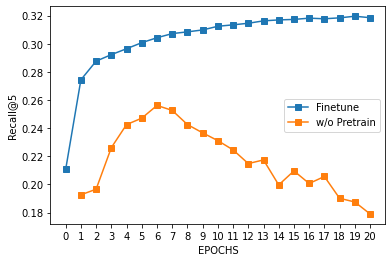

time: 295 ms


In [151]:
value1 = ft_recall_5
value2 = cs_recall_5

length = len(value1)
plt.plot(range(length), value1, "-s", label="Finetune")
plt.plot(range(1, length), value2, "-s", label="w/o Pretrain")


plt.xticks(range(length))
plt.ylabel('Recall@5')
plt.xlabel("EPOCHS")
plt.legend()
plt.show()

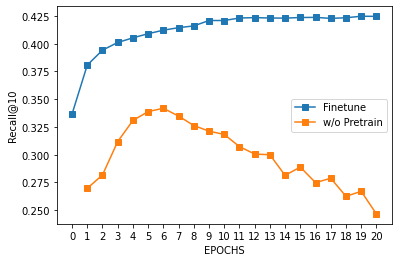

time: 229 ms


In [152]:
value1 = ft_recall_10
value2 = cs_recall_10
name = "Recall@10"

length = len(value1)
plt.plot(range(length), value1, "-s", label="Finetune")
plt.plot(range(1, length), value2, "-s", label="w/o Pretrain")


plt.xticks(range(length))
plt.ylabel(name)
plt.xlabel("EPOCHS")
plt.legend()
plt.show()

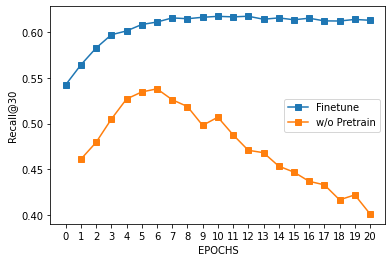

time: 208 ms


In [154]:
value1 = ft_recall_30
value2 = cs_recall_30
name = "Recall@30"

length = len(value1)
plt.plot(range(length), value1, "-s", label="Finetune")
plt.plot(range(1, length), value2, "-s", label="w/o Pretrain")


plt.xticks(range(length))
plt.ylabel(name)
plt.xlabel("EPOCHS")
plt.legend(loc='center right')
plt.show()